In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.device_manager import DeviceManager
from swiper2.window_builder import WindowBuilder
from swiper2.window_manager import SlidingWindowManager
from swiper2.decoder_manager import DecoderManager
from swiper2.simulator import DecodingSimulator
import swiper2.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [3]:
scheduling_method = 'parallel'

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [4]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [5]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [6]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 131it [00:00, 22973.36it/s]


In [7]:
decoding_data.num_rounds

131

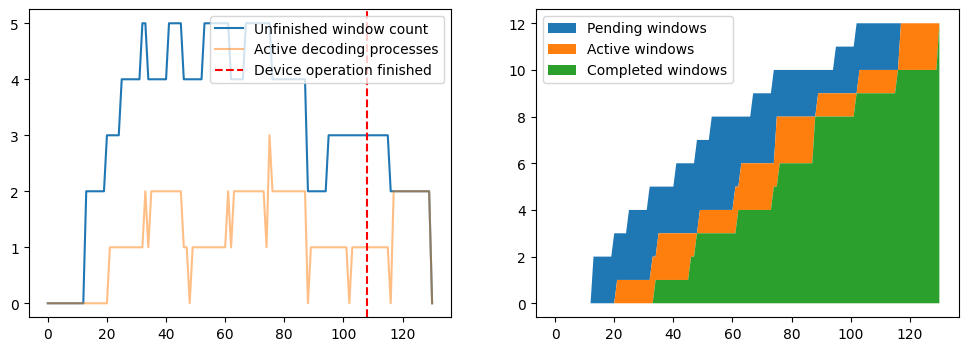

In [8]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe that the number of active decoding processes is far lower, but the rate
of completing windows remains the same.

<Axes3D: >

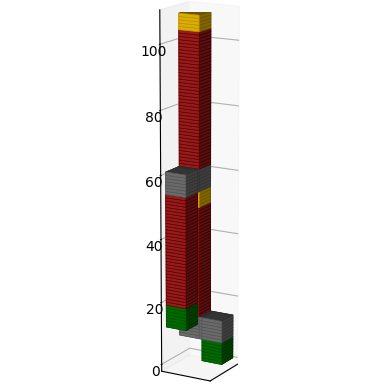

In [9]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

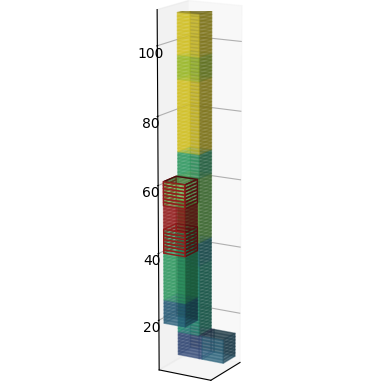

In [10]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[7]
)

## 15 - 1 Factory

In [11]:
d=15
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [12]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [13]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 277it [00:00, 1894.39it/s]


In [14]:
len(simulator._window_manager.all_windows)

141

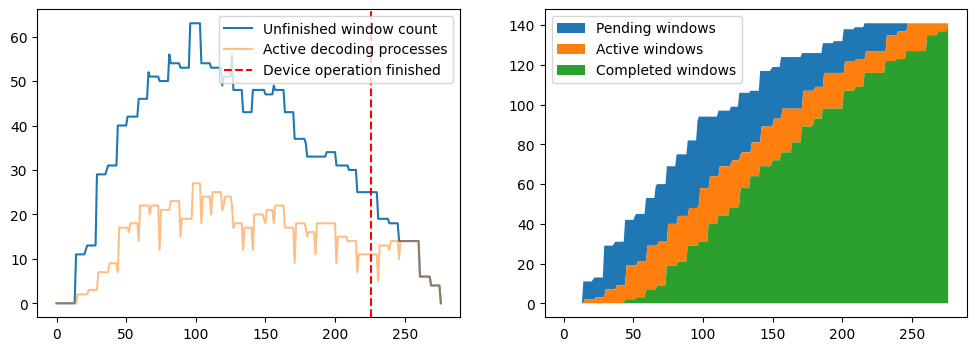

In [16]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Text(0.5, 0.92, 'parallel (277 rounds)')

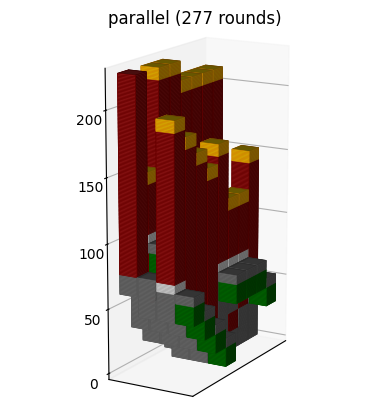

In [17]:
plotter.plot_device_schedule_trace(device_data, spacing=1)
plt.title(f'{scheduling_method} ({decoding_data.num_rounds} rounds)')

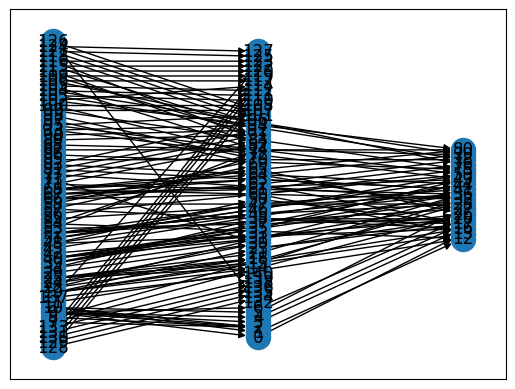

In [18]:
draw_dag(window_data.window_dag)

<Axes3D: >

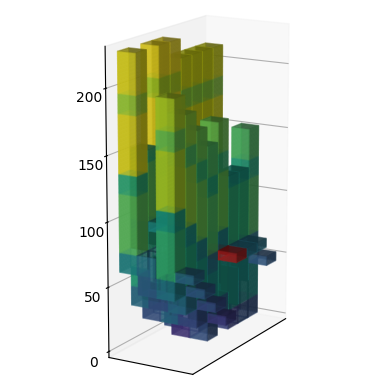

In [19]:
selected_window_idx_1 = -1
for i,window in enumerate(window_data.all_windows):
    if selected_window_idx_1 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (3,3):
            selected_window_idx_1 = i
            break

selected_window_idx_2 = -1
for i,window in enumerate(window_data.all_windows):
    if selected_window_idx_2 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (2,7) and cr.duration == 3:
            selected_window_idx_2 = i
            break

window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    spacing=1,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
    window_buffers_to_highlight=[selected_window_idx_1, selected_window_idx_2],
)

# Stress test

In [20]:
d=7
decoding_time = 2*d
speculation_time = 2
speculation_accuracy = 0.7

In [21]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [22]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(100, 0).schedule,
    scheduling_method=scheduling_method,
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 4817it [00:02, 2064.78it/s]


4801 4817


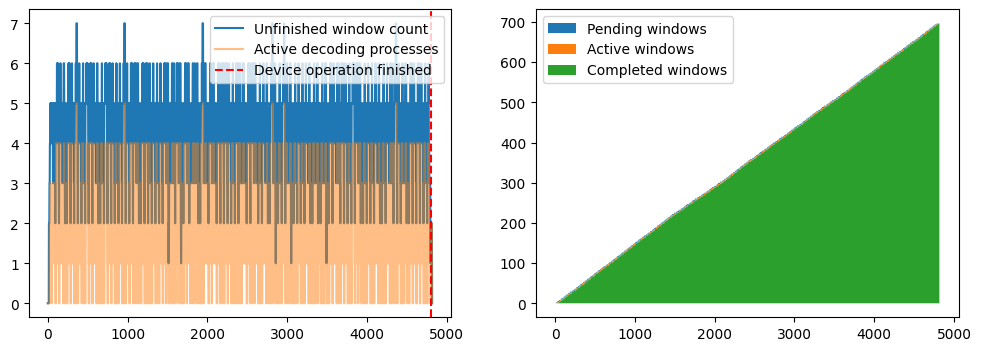

In [23]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

In [24]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(100, 0).schedule,
    scheduling_method='aligned',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 3470it [00:01, 2257.03it/s]

3454 3470


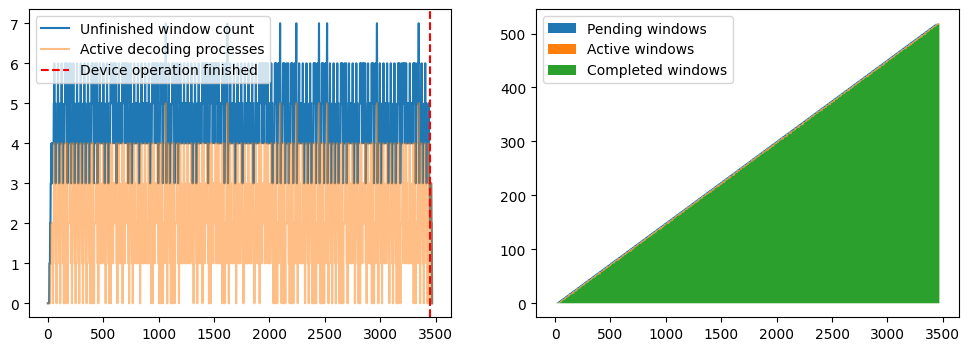

In [25]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()